# Data poisoning on image classification models

We perform targeted and untargeted label flipping attacks on a CNN classification model trained on the MNIST dataset.

> 🚧 **WARNING**
> 
> Running this entire notebook can take from 30 minutes to more than an hour. In particular, plotting the curves take a long time due to repeated model training. It is highly recommended to run this notebook on a GPU. Alternatively, you can choose not to run the first cells of this notebook up to _The impact of model dimension_. Check the running times for each cell, it's up to your decision.

If you want to delve deeper into the code used for label flipping, see the file `image_classification/label_flipping.py`.

### Imports

We use `matplotlib` `pandas`, `scikit-learn` and `seaborn` for visualization. `torchinfo` provides a nice Keras-style model summary.
`tqdm` powers nice-looking progress bars.
Most of the code is written in `pytorch`.

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torchinfo

In [2]:
from image_classification.utils import seed_all_generators, use_tqdm
from image_classification.accel import BEST_DEVICE, optimize_model
from image_classification.nn import Hyperparameters, OptimizerParams

# For deterministic results
seed_all_generators(0x2023_2024)

# NOTE: Don't forget to clear all outputs in vscode before running.
# 
# WARNING (Windows): consider setting ascii=True and installing vscode-tqdm
# if notebook display issues persist: https://pypi.org/project/vscode-tqdm/
# Alternatively, set enable=False (but there won't be interactive output).
use_tqdm(enable=False, ascii=False)

Using cuda device


## Datasets

### Load data

In [3]:
from image_classification.datasets import (
    class_weights,
    mnist_train_test,
)

training_data, test_data = mnist_train_test(root='data')

### Class weights

In [4]:
class_weights(training_data)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [5]:
class_weights(test_data)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

The test dataset is mostly balanced: the highest relative difference between class weights is around 25 %.

That means we don't have to set the weights for `CrossEntropyLoss`.

In our threat model, we consider that the victim assumes balanced classes. Therefore, `CrossEntropyLoss` will be always be used unweighted **even if label flipping creates class unbalance.**

## Data visualization

Below we perform a principal component analysis (PCA) by visualizing the flattened images on a three-dimensional space.

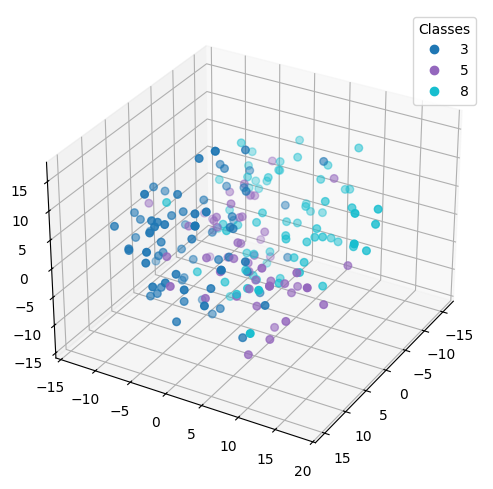

In [6]:
from image_classification.visualize import plot_pca

#%matplotlib tk
plot_pca(test_data, classes=[3, 5, 8])
#%matplotlib inline

It should become clear that some samples of 3, 5 and 8 can easily be confused.

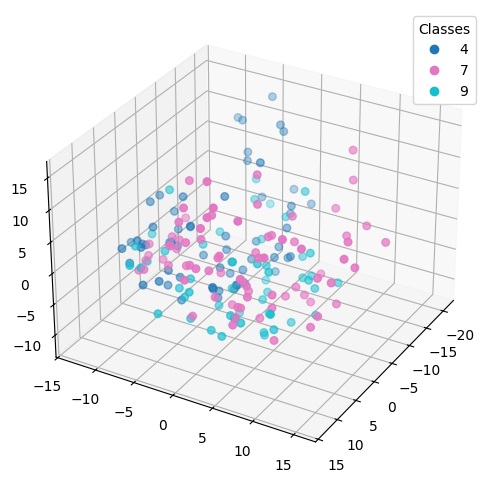

In [7]:
plot_pca(test_data, classes=[4, 7, 9])

It should become clear that some samples of 4, 7 and 9 can easily be confused.

## Base Model

We use a ConvNet-like architecture with one or two convolution layers and one perceptron with a hidden layer.

In [8]:
from image_classification.models import BigCNN, SmallCNN

In [9]:
big_model = optimize_model(BigCNN())
big_reg_model = optimize_model(BigCNN(batchnorm=True, dropout_rate=0.2))
small_model = optimize_model(SmallCNN())

### Parameter info

In [10]:
big_model_summary = torchinfo.summary(big_model)
big_model_summary

Layer (type:depth-idx)                   Param #
BigCNN                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       2,320
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       200,960
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       2,570
Total params: 206,010
Trainable params: 206,010
Non-trainable params: 0

In [11]:
big_reg_model_summary = torchinfo.summary(big_reg_model)
big_reg_model_summary

Layer (type:depth-idx)                   Param #
BigCNN                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       2,320
│    └─BatchNorm2d: 2-6                  32
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       200,960
│    └─ReLU: 2-10                        --
│    └─Dropout: 2-11                     --
│    └─Linear: 2-12                      2,570
Total params: 206,074
Trainable params: 206,074
Non-trainable params: 0

In [12]:
small_model_summary = torchinfo.summary(small_model)
small_model_summary

Layer (type:depth-idx)                   Param #
SmallCNN                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       40
│    └─BatchNorm2d: 2-2                  8
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-5                       50,240
│    └─ReLU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Linear: 2-8                       650
Total params: 50,938
Trainable params: 50,938
Non-trainable params: 0

In terms of parameter count, the `SmallCNN` model is 4 times smaller than `BigCNN`.

Note how the model dimensions here (50k-200k) are much higher than the input dimensions (784).

### Hyperparameters

In [13]:
from pprint import pprint

HP = Hyperparameters()

# We will use the same batch size in all of this notebook
BATCH_SIZE = HP.batch_size

pprint(HP)

Hyperparameters(batch_size=64,
                inference_batch_size=128,
                epochs=1,
                loss_fn=CrossEntropyLoss(),
                optimizer=<class 'torch.optim.adamw.AdamW'>,
                optimizer_params=OptimizerParams(lr=0.001, weight_decay=0.001),
                metric=MulticlassAccuracy())


The hyperparameters above were found to be near-optimal for our model architecture.

### Train / test loops

In [14]:
# NOTE: the dataset is already shuffled.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
from image_classification.nn import train_val_loop

In [ ]:
train_val_loop(
    big_model,
    train_dataloader, test_dataloader,
    **HP.train_test_params(big_model),
)

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100%|██████████| 10000/10000 [00:00<?, ?it/s]


In [ ]:
train_val_loop(
    big_reg_model,
    train_dataloader, test_dataloader,
    **HP.train_test_params(big_reg_model),
)

100%|██████████| 10000/10000 [00:00<?, ?it/s]


In [ ]:
train_val_loop(
    small_model,
    train_dataloader, test_dataloader,
    **HP.train_test_params(small_model),
)

100%|██████████| 10000/10000 [00:00<?, ?it/s]


The bigger and the smaller model have comparable performance on the test set.

## CNN model introspection

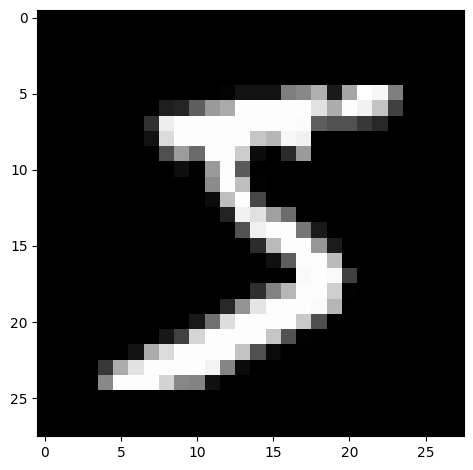

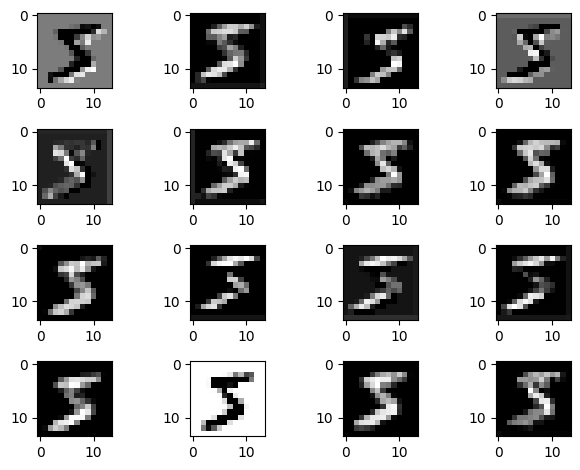

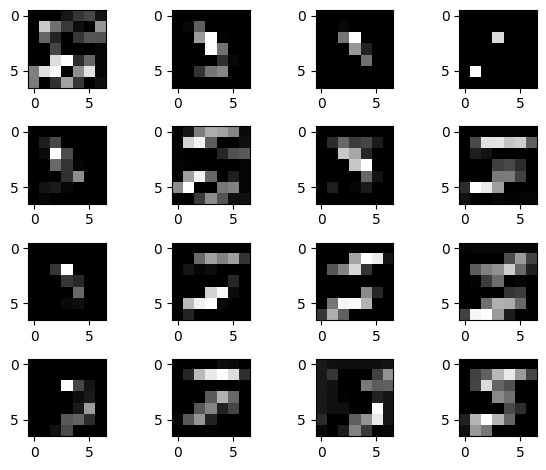

In [19]:
from image_classification.visualize import display_cnn_features

x = next(iter(DataLoader(training_data)))[0]
display_cnn_features(big_model, x)

## Evaluation

In order to have a metric value per class, we use the F1-score. This metric is also useful when label flipping creates class imbalance.

In [20]:
from image_classification.evaluate import labels_and_predictions

### Confusion matrix and F1-score

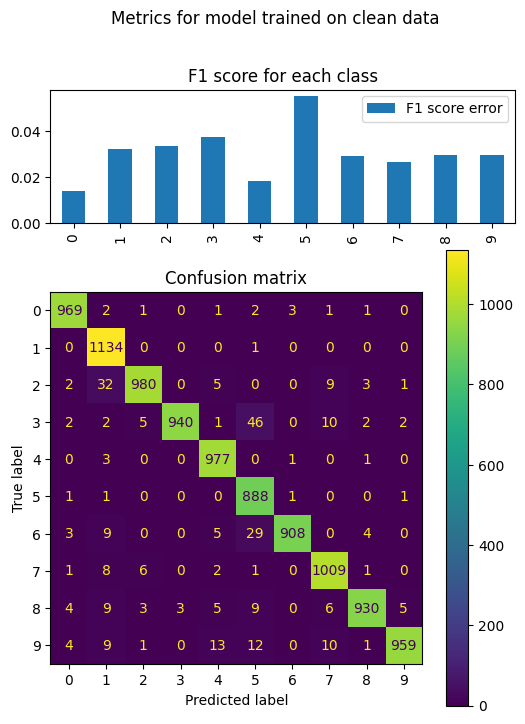

In [21]:
def display_metrics(model, dataset, fig=None, suptitle='Evaluation metrics'):
    y_true, y_pred = labels_and_predictions(model, dataset)
    f1_score_err = 1. - f1_score(y_true, y_pred, average=None)
    df = pd.DataFrame(data={'F1 score error': f1_score_err})

    if fig is None:
        fig = plt.figure(figsize=(6, 8))
    if suptitle:
        fig.suptitle(suptitle)
    gs = fig.add_gridspec(nrows=4, ncols=1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1:])
    ax1.set_title('F1 score for each class')
    ax2.set_title('Confusion matrix')

    df.plot.bar(y='F1 score error', ax=ax1)
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax2)
    return f1_score_err, cm


display_metrics(big_model, test_data, suptitle='Metrics for model trained on clean data');

### Display loss statistics by class

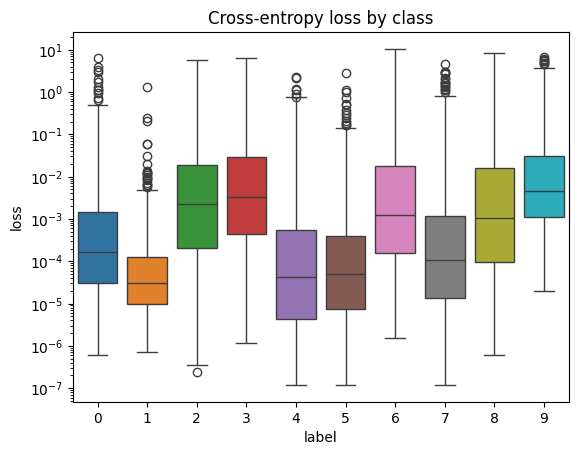

In [22]:
def display_loss(model, dataset, loss_fn):
    y_true, logits = labels_and_predictions(model, dataset, as_logits=True)
    df = pd.DataFrame({
        'label': y_true,
        'loss': loss_fn(logits, y_true),
    })
    sns.boxplot(df, x='label', y='loss', hue='label', legend=None, log_scale=(False, True), palette='tab10')

display_loss(big_model, test_data, CrossEntropyLoss(reduction='none'))
plt.title('Cross-entropy loss by class');

Promising candidates for label flipping include 9 and 3.

## Label flipping

### Flipping labels adversarially

This attack assumes we have access to the top-2 predictions of the classifier.

### Most frequent confusions

In [23]:
def print_most_frequent_confusions(model, dataset):
    y_true, y_pred = labels_and_predictions(model, dataset)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    np.fill_diagonal(cm, 0)
    
    df = pd.DataFrame({
        'Most frequently confused with': cm.argmax(axis=-1),
        'Percentage': 100.0 * cm.max(axis=-1),
    })
    df.index.name = 'Class'
    df.sort_values(by='Percentage', ascending=True)

    pd.options.display.float_format = '{:.2f}'.format
    print(df)

print_most_frequent_confusions(big_model, test_data)

       Most frequently confused with  Percentage
Class                                           
0                                  6        0.31
1                                  5        0.09
2                                  1        3.10
3                                  5        4.55
4                                  1        0.31
5                                  0        0.11
6                                  5        3.03
7                                  1        0.78
8                                  1        0.92
9                                  4        1.29


## Results

In [24]:
from image_classification.label_flipping import (
    LabelFlippingAttack,
    
    eval_perf_under_attack, eval_perf_many_under_attack,
)

### Train a new victim from scratch on the poisoned dataset

In [25]:
def label_flipping_attack_comparison(
        base_model,
        victim,
        training_data=training_data,
        test_data=test_data,
        targets=None,
        flip_proportions=[0.2, 0.5],
        target_low_loss=False,
        hyperparams=Hyperparameters(),
        title='',
    ):
    victim = victim.to(BEST_DEVICE)
    inital_state = victim.state_dict()

    nrows = (len(flip_proportions) + 1) // 2
    fig = plt.figure(layout='constrained', figsize=(10, 6 * nrows))
    fig.suptitle(title)
    subfigs = fig.subfigures(nrows, 2, wspace=0.07)

    for fp, fig in zip(flip_proportions, subfigs.flatten()):
        # Reset the neural network at each iteration
        victim.load_state_dict(inital_state)

        attack = LabelFlippingAttack(flip_proportion=fp, targets=targets)
        victim = attack.perform(
            base_model, victim,
            training_data,
            target_low_loss=target_low_loss,
            hyperparams=hyperparams,
        )
        
        display_metrics(victim, test_data, fig=fig, suptitle=f'Label flipping proportion: {fp}')

### Indiscriminate label flipping

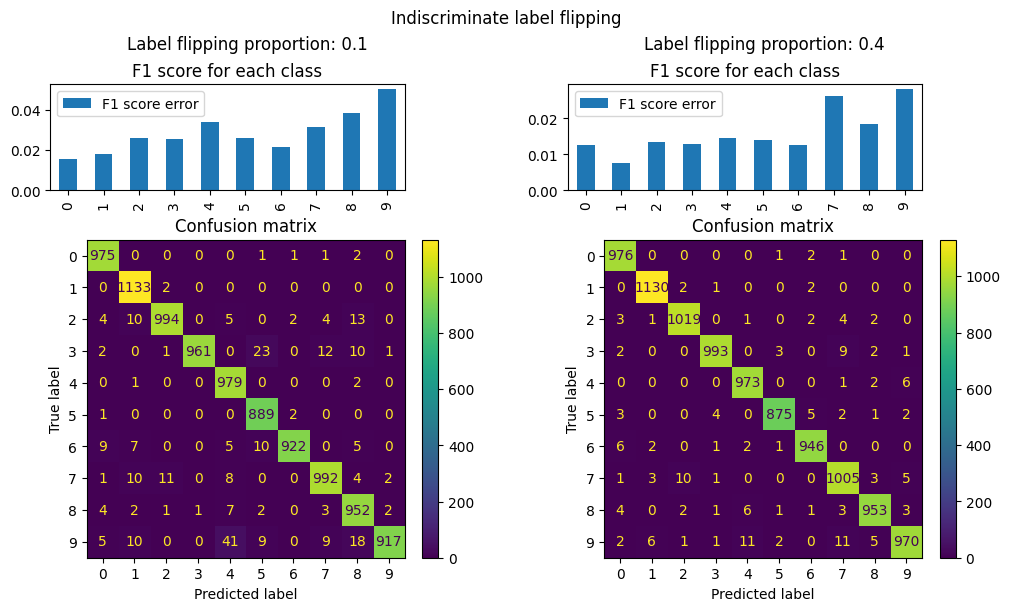

In [26]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.1, 0.4],
    targets=None,
    title=f'Indiscriminate label flipping',
)

**A surprising result here!**

The model's performance remains surprisingly good against untargeted label flipping. This result can be attributed to two factors:
- The label noise is mostly eliminated by AdamW's quick convergence and regularization effect
- Since untargeted label flipping is unbiased (i.e the class weights are not affected and no label is favored in the predictions), the model is unlikely to overfit to the noise.

Changing our point of view to adversarial learning: noisy labels might be a good way to improve model resilience against targeted data poisoning.

In particular, **noisy labels act as a form of output layer regularization**. Thus, we may apply our existing intuition from the `Dropout` layer: noisy labels are useful when the model is overfitting.

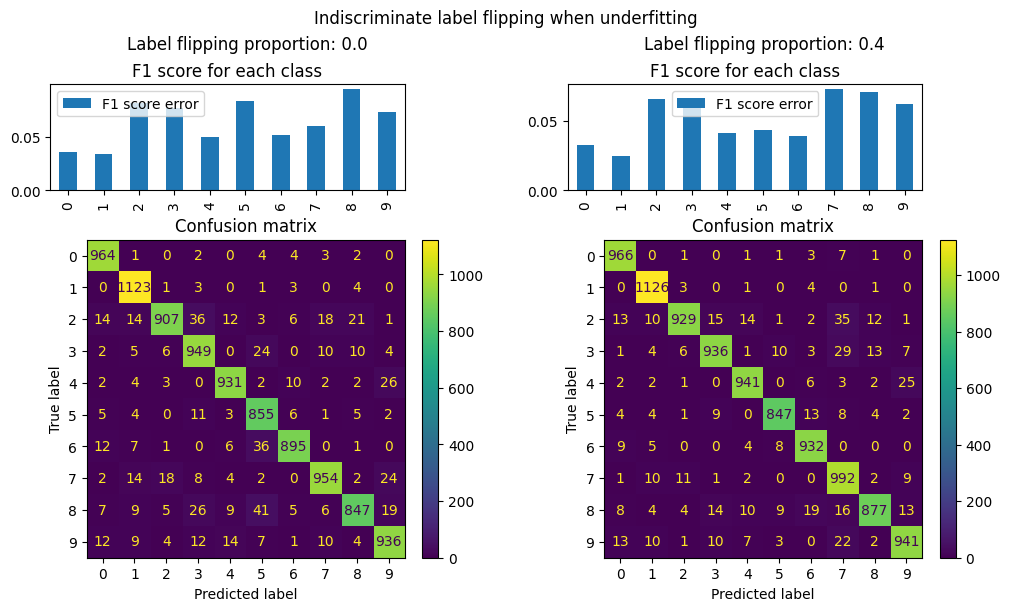

In [27]:
hp = Hyperparameters(
    optimizer_params=OptimizerParams(lr=1e-4)
)

label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.0, 0.4],
    targets=None,
    hyperparams=hp,
    title='Indiscriminate label flipping when underfitting',
)

Surprisingly, indiscriminate label flipping did not hurt the global performance of the model at all, even with 40 % poisoning rate. This wouldn't be the case when using an optimizer such as SGD which performs worse than AdamW.
TODO: do this comparison

However, the confusions might be concentrated towards the most frequent errors (the confusion matrix becomes sparser).
This is an interesting property for stealthy, targeted poisoning attacks.


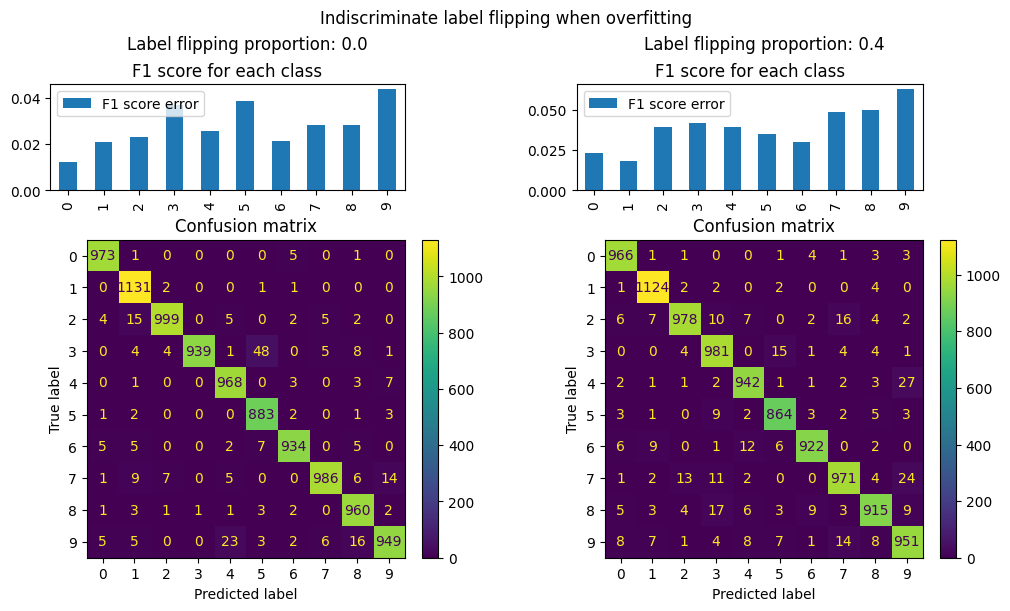

In [28]:
hp = Hyperparameters(
    optimizer_params=OptimizerParams(lr=1e-2)
)

label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.0, 0.4],
    targets=None,
    hyperparams=hp,
    title='Indiscriminate label flipping when overfitting',
)

When the model is overfitting, the effect of label flipping is reversed:
- the global performance is unchanged
- the performance on individual labels is made more homogeneous
- the confusion matrix is less sparse, which means the model makes more many small errors but less many large errors

**Conclusion:**
- When overfitting, noisy labels help removing bias towards some errors in the model predictions
- When underfitting, noisy labels improve performance on most cases, at the cost of amplifying the highest errors. The remaining located errors could be mitigated via machine unlearning for instance.

This can be seen as a case of the _no free lunch_ theorem in optimization.

#### The influence of flip proportion on performance

We use F1-score for each class as our performance criterion.

In [29]:
def plot_f1_fp_curve(
    base_model,
    victim,
    training_data=training_data,
    test_data=test_data,
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets: list | dict = None,
    rounds: int = 2,
    target_low_loss=False,
    hyperparams=Hyperparameters(),
    title='',
):
    """
    See `eval_perf_under_attack` for documentation over the parameters.
    """
    
    results = eval_perf_under_attack(
        base_model, victim,
        training_data, test_data,
        flip_proportion, targets, rounds,
        target_low_loss, hyperparams,
        metric='f1_score'
    )
    g = sns.pointplot(
        data=results,
        x='flip_proportion',
        y='f1_score',
        hue='class',
        palette='tab10',
    )
    g.set_xlabel('Proportion of flipped labels')
    g.set_ylabel(f'F1 score (averaged over {rounds} rounds)')
    # Forces rounding on xticks
    g.xaxis.set_ticklabels([
        plt.Text(t._x, t._y, f'{float(t._text):.3g}')
        for t in g.xaxis.get_ticklabels()
    ])
    g.set_title(title)
    return results, g

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0212 14:14:36.070000 74874 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


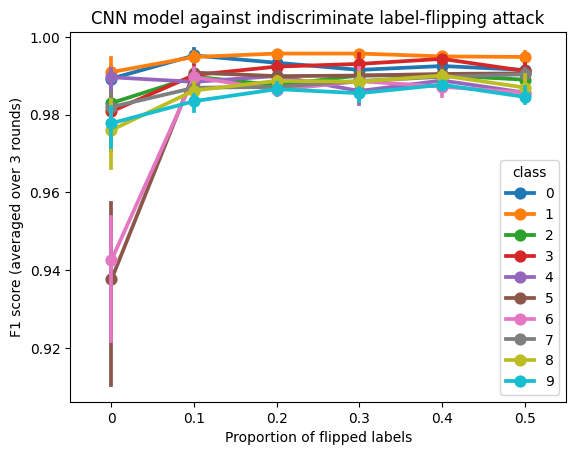

In [30]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    targets=None,
    rounds=3,
    title='CNN model against indiscriminate label-flipping attack',
);

Except for very high poisoning rates (> 80 %), the model performance increases with label flipping and remains exceedingly high.

This showcases the efficiency of techniques such as **noisy labels learning** (this technique), label smoothing (see below). Even if the data is not pointwise correct, the model manages to perform well via internal majority vote.

In [31]:
CrossEntropyLoss(label_smoothing=0.1)

CrossEntropyLoss()

Another approach is to introduce noise on the input features instead of the output labels, for instance with [randomized smoothing](https://arxiv.org/abs/2002.03018).

### Targeted label swapping

Label swapping is interesting since it preserves class weights. In the following experiments, we analyze the effect of swapping on only two classes.

Unfortunately, the confusion matrix is not symmetric, so choosing the swapped pair based on the highest confusion coefficient (3 and 5) may not be the best strategy.

Instead, we target classes which have the closest internal representation in the network. From the PCA, classes 9 and 7 look promising.

We choose to analyze the effect of label swapping with proportion $r < 0.5$. Indeed, label swapping with $r > 0.5$ is symmetrical with $1 - r$.

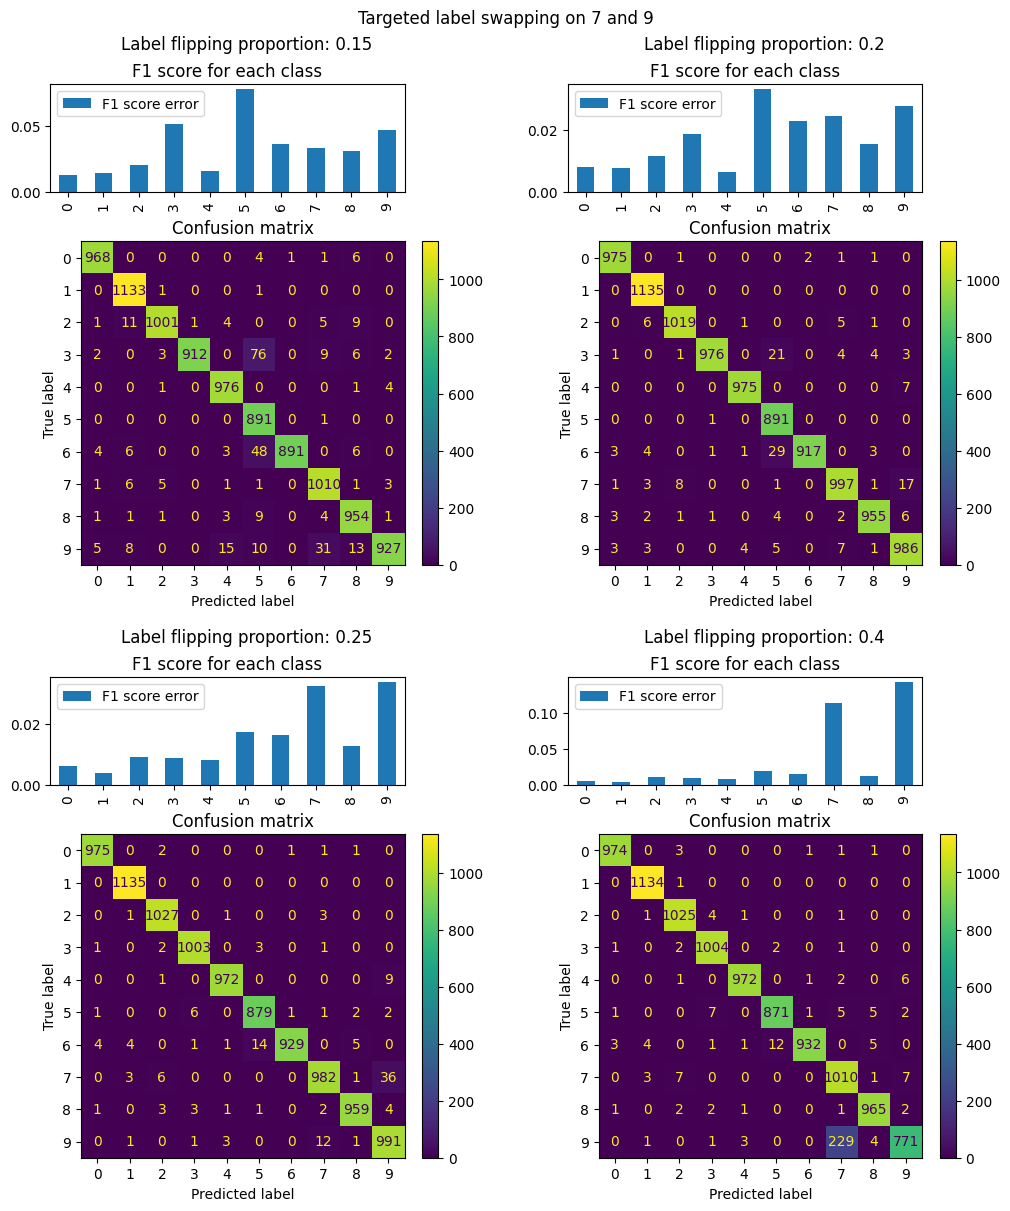

In [32]:
label_flipping_attack_comparison(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportions=[0.15, 0.2, 0.25, 0.4],
    targets={9: 7, 7: 9},
    title='Targeted label swapping on 7 and 9',
);

**Observations:**

- Under $r \ge 0.2$, the effect of label swapping is very small and sometimes beneficial, similar to indiscriminate label flipping. The confusion rates are not monotonic.
- With $r \sim 0.4$, label swapping starts to become detrimental for model performance. Incidentally, the F1-scores on other classes improve a lot.

**Possible line of research:** targeted label swapping might have an effect on untargeted classes. We may conjecture that label swapping affects the internal representation of 7 and 9, so the orthogonality between classes is also distorted.

However, such an hypothesis is not verified here.

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


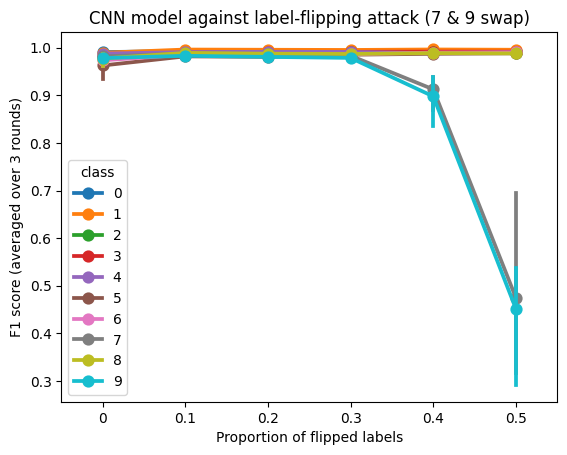

In [33]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={7: 9, 9: 7},
    rounds=3,
    title='CNN model against label-flipping attack (7 & 9 swap)',
);

Observation: the accuracy quicly drops around 40 % since the model cannot decide of the true label by majority vote anymore. However the performance numbers are very unpredictable.

### Swapping two highly orthogonal features

Below we perform label swapping on two classes that are very different: 0 and 1.

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


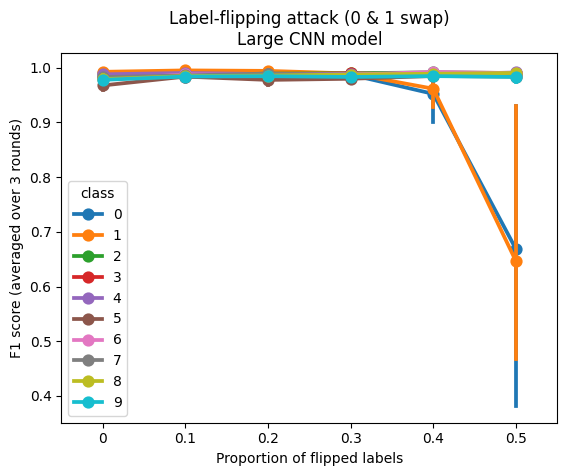

In [34]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={0: 1, 1: 0},
    rounds=3,
    title='Label-flipping attack (0 & 1 swap)\nLarge CNN model',
);

Since 0 and 1 are easily distinguishable, the model resists well with $r \le 0.3$.

### Swapping more than 2 classes

We swap labels in a circular permutation: 0 -> 1 -> ... -> 9 -> 0.

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


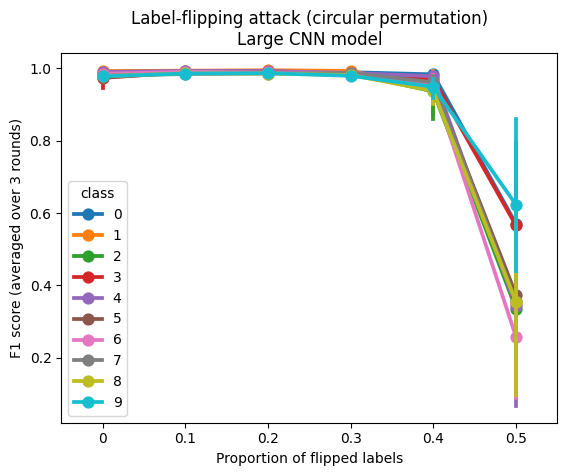

In [35]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={i: (i + 1) % 10 for i in range(10)},
    rounds=3,
    title='Label-flipping attack (circular permutation)\nLarge CNN model',
);

Circular label flipping biases the model and affects all of the model's internal representations of each classes. However, the performance drop is roughly the same as before.

### Targeted label-flipping on low-loss samples

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


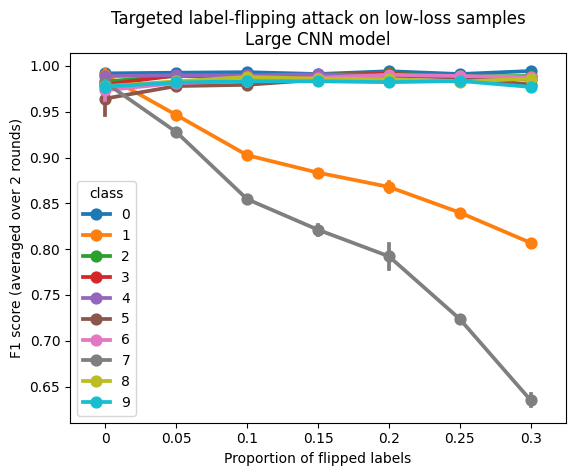

In [36]:
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss=True,
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nLarge CNN model',
);

Targeting samples with low loss is an efficient strategy. The model accuracy quicly drops within $0 < r < 0.1$.

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


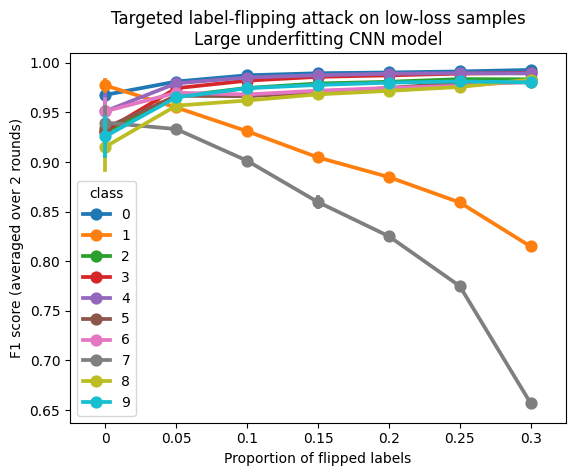

In [37]:
hp = Hyperparameters(
    optimizer_params=OptimizerParams(lr=1e-4)
)

plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss=True,
    rounds=2,
    hyperparams=hp,
    title='Targeted label-flipping attack on low-loss samples\nLarge underfitting CNN model',
);

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


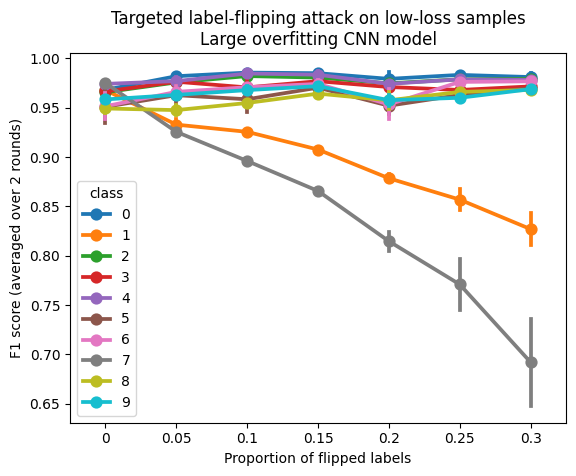

In [38]:
hp = Hyperparameters(
    optimizer_params=OptimizerParams(lr=1e-2)
)
plot_f1_fp_curve(
    base_model=big_model,
    victim=BigCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss=True,
    rounds=2,
    hyperparams=hp,
    title='Targeted label-flipping attack on low-loss samples\nLarge overfitting CNN model',
);

**Choosing the wrong learning rate causes underfitting or overfitting, which can harm the model's performance on targeted attacks.**

### Targeted label flipping on a regularized model

This regularized model has a batch normalization layer and a dropout layer.

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


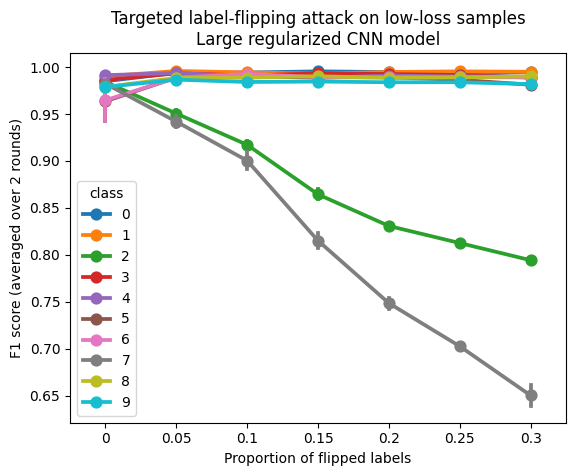

In [39]:
plot_f1_fp_curve(
    base_model=big_reg_model,
    victim=BigCNN(batchnorm=True, dropout_rate=0.2),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss=True,
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nLarge regularized CNN model',
);

### Targeted label flipping on a smaller model

W0212 14:20:29.918000 74874 torch/_dynamo/convert_frame.py:906] [0/8] torch._dynamo hit config.cache_size_limit (8)
W0212 14:20:29.918000 74874 torch/_dynamo/convert_frame.py:906] [0/8]    function: 'forward' (/home/lvt/dev/python/ml/psc/playground/implementations/projects/poisoning/image_classification/models.py:67)
W0212 14:20:29.918000 74874 torch/_dynamo/convert_frame.py:906] [0/8]    last reason: 0/0: GLOBAL_STATE changed: grad_mode 
W0212 14:20:29.918000 74874 torch/_dynamo/convert_frame.py:906] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0212 14:20:29.918000 74874 torch/_dynamo/convert_frame.py:906] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


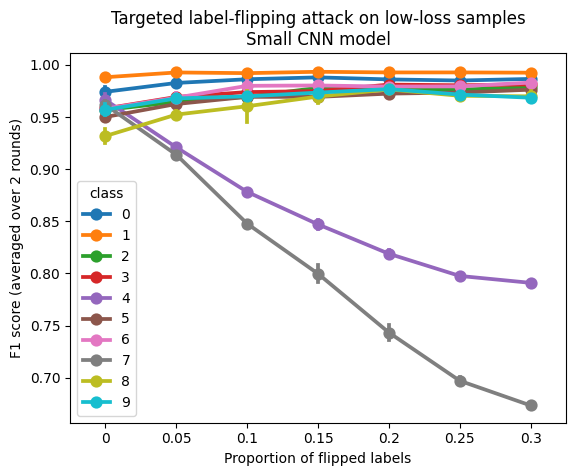

In [40]:
plot_f1_fp_curve(
    base_model=small_model,
    victim=SmallCNN(),
    flip_proportion=np.linspace(0.0, 0.3, 7),
    targets=[7, 9],
    target_low_loss=True,
    rounds=2,
    title='Targeted label-flipping attack on low-loss samples\nSmall CNN model',
);

Smaller models and regularized models resist targeted label flipping extremely well: the performance remains roughly constant even with high poisoning rates. Since their performance are almost on par with the bigger model, the main difference is thir ability to resist overfitting.

**Vulnerability to targeted attacks is correlated to the ability to overfit.**

**Relevant topics:** data amplification, bias.

## The impact of model dimension

Below we study the impact of the model dimension (number of trainable parameters) on its performance against label flipping.

We perform a circular permutation of the labels under different poisoning rates between 0 % and 50 %. Even if the optimal attack strongly depends on the model dimension, using the same attack makes it easer to compare the performances of every victim model.

In [41]:
import torchinfo

def plot_f1_fp_dim_curves(
        victims: list[nn.Module],
        results: pd.DataFrame,
        classes: list,
        title='Targeted label flipping',
    ):
    """
    For each label flipping proportion, plot the model performance
    against the model dimension.

    The model performance is computed as the geometric mean
    of the F1 scores of each class.
    """

    dimensions = {
        i: torchinfo.summary(victim).trainable_params
        for (i, victim) in enumerate(victims)
    }
    #`num_params` is added, equal to the number of trainable parameters of each victim.
    results['num_params'] = results['victim'].map(dimensions)
    results.drop(columns='victim', inplace=True)

    flip_proportion = results['flip_proportion'].unique()
    flip_proportion.sort()

    nrows = (len(flip_proportion) + 1) // 3
    fig, axes = plt.subplots(nrows=nrows, ncols=3)
    fig.set_figwidth(10)
    fig.set_figheight(5 * nrows)
    fig.suptitle(title)

    for (fp, ax) in zip(flip_proportion, axes.flatten()):
        df = results[
            (results['flip_proportion'] == fp)
            & (results['class'].isin(classes))
        ]
        # Geometric mean over each class F1 score
        df['f1_score'] = np.log(df['f1_score'])
        df = df.groupby('num_params', as_index=False)['f1_score'].mean()
        df['f1_score'] = np.exp(df['f1_score'])
        
        g = sns.pointplot(
            data=df,
            x='num_params',
            y='f1_score',
            #hue='class',
            #palette='tab10',
            ax=ax,
            log_scale=(True, False),
            native_scale=True,
        )
        g.set_xlabel('Model dimension (number of parameters)')
        g.set_ylabel('F1 score (geomean across classes)')
        g.set_title(f'{round(100 * fp)} % label flipping')

    fig.tight_layout()

### Performance results for larger models

In [42]:
big_victims = [
    BigCNN(hidden_layer_dim=dim)
    for dim in [8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 512, 1024]
]
results_bigmodels = eval_perf_many_under_attack(
    victims=big_victims,
    training_data=training_data,
    test_data=test_data,
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={i: (i + 1) % 10 for i in range(10)},
    rounds=[5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    target_low_loss=True,
    metric='f1_score',
)

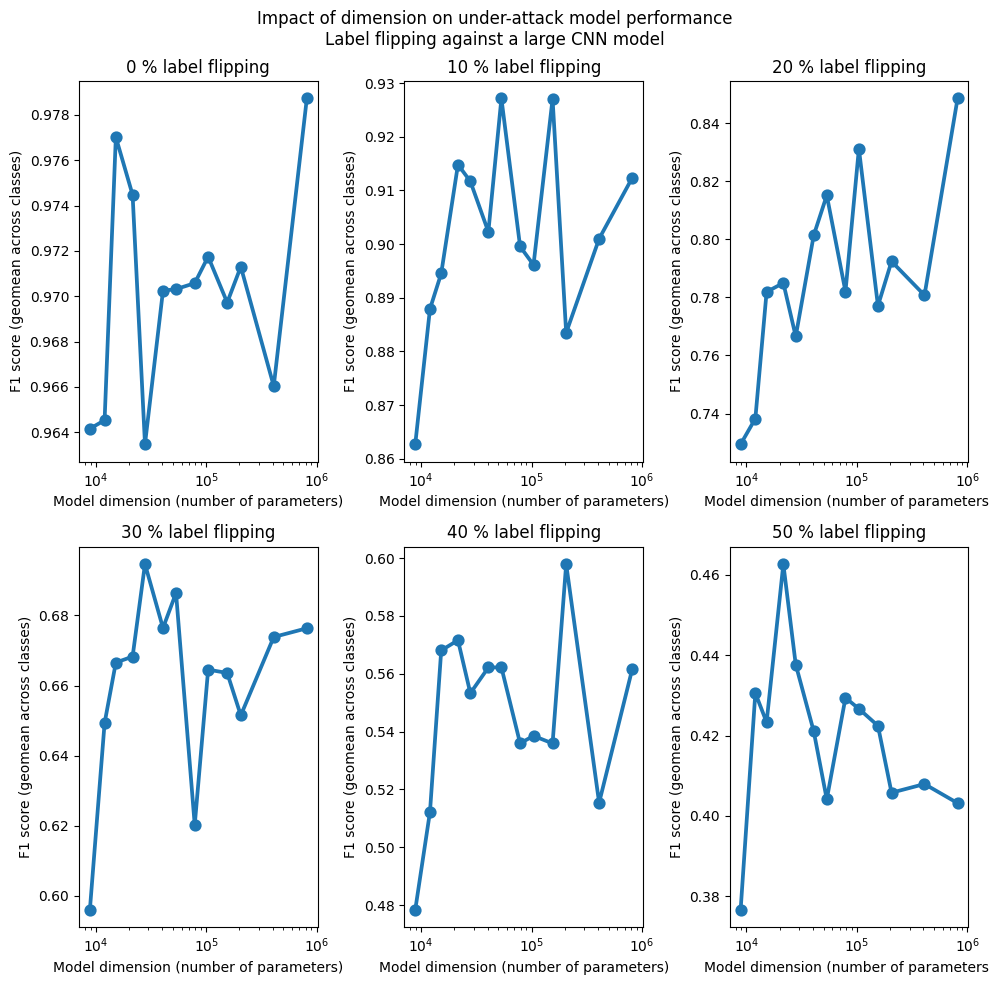

In [43]:
plot_f1_fp_dim_curves(
    big_victims,
    results_bigmodels,
    classes=list(range(10)),
    title='Impact of dimension on under-attack model performance\n'
          'Label flipping against a large CNN model',
);

The model performance oscillates with the number of parameters. Note that the y-axis bounds and scales differ between all of these diagrams, and the x-axis is logarithmic.

There are three main patterns here:
- With no data poisoning, the model performance reaches a maximum around $10^4$ parameters and then plateaus. We can infer that the regularizing effect of the optimizer (`AdamW(weight_decay=...)`) prevents performance drop due to overfitting.
- With low data poisoning rates (1 - 10 %), the model performance continues to increase until reaching $10^5$ parameters where it stagnates. This results from the regularizing effect of noisy labels.
- With higher data poisoning rates, the model performance peaks between $10^4$ and $10^5$ parameters and slowly decreases, most likely due to overfitting.

### Performance results for smaller models

In [44]:
small_victims = [
    SmallCNN(hidden_layer_dim=dim)
    for dim in [8, 12, 16, 24, 32, 48, 64]
]
results_smallmodels = eval_perf_many_under_attack(
    victims=small_victims,
    training_data=training_data,
    test_data=test_data,
    flip_proportion=np.linspace(0.0, 0.5, 6),
    targets={i: (i + 1) % 10 for i in range(10)},
    rounds=[5, 4, 3, 2, 1, 1, 1],
    target_low_loss=True,
    metric='f1_score',
)

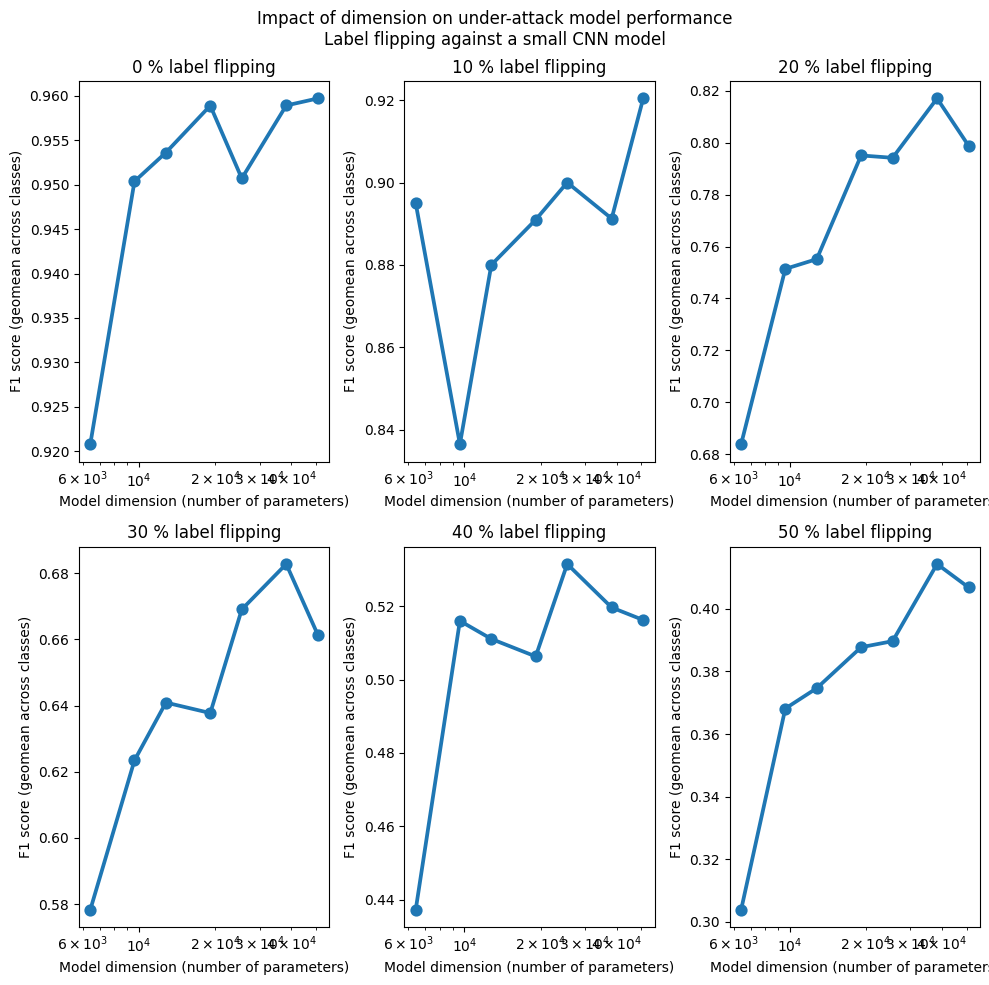

In [45]:
plot_f1_fp_dim_curves(
    small_victims,
    results_smallmodels,
    classes=list(range(10)),
    title='Impact of dimension on under-attack model performance\n'
          'Label flipping against a small CNN model',
);

The trend is clearer here (note that `SmallCNN` benefits from slight regularization).

With low poisoning rates (10 - 20 %), the model performance first decreases, before reaching a local minima around 25000 parameters, then sharply increases. This is in line with our previous conclusions that larger models can benefit from noisy labels. The difference here is that the noise introduced here by label flipping is non-uniform and biased.

## Label flipping on fine-tuning

Finally, we consider a different threat model. The victim first pretrains a model on a clean dataset. Afterwards, the attacker performs a label-flipping attack on a second, smaller dataset. Finally, the victim fine-tunes the pretrained model on this poisoned dataset.

### Initial pre-training

In [ ]:
pretrained = BigCNN().to(BEST_DEVICE)

# First, pre-train the model on a large clean dataset for a "long" time period
train_val_loop(
    pretrained,
    train_dataloader, test_dataloader,
    **HP.train_test_params(pretrained),
    keep_pbars=False,
)

### Finetuning attack

We emulate finetuning by training on a smaller dataset with a lower learning rate.

We assume the attacker can poison 100 % of the fine-tuning dataset. This scenario gives the most convincing results, as we will see later.

In [47]:
def finetuning_attack(
        pretrained_model: nn.Module,
        finetuning_size: int,
        learning_rate: float,
        targets: list[int] | dict[int, int],
    ):
    # We use the test dataset since it is disjoint from the train dataset.
    # We keep the first elements for finetuning and the rest for testing.
    sizes = [finetuning_size, len(test_data) - finetuning_size]
    [finetuning_data, test_data2] = test_data.split(sizes)

    # Perform some "fine-tuning" on poisoned data
    hp = Hyperparameters(
        optimizer_params=OptimizerParams(lr=learning_rate)
    )
    
    attack = LabelFlippingAttack(flip_proportion=1.0, targets=targets)
    return attack.perform(
        base_model=pretrained_model,
        victim=deepcopy(pretrained_model),
        training_data=finetuning_data,
        test_data=test_data2,
        hyperparams=hp,
    )

### Results

/tmp/ipykernel_74874/386514557.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.xaxis.set_ticklabels([


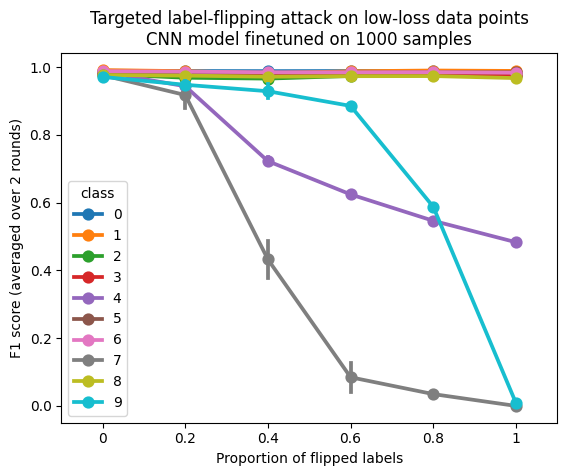

In [48]:
finetuning_size = 1000
sizes = [finetuning_size, len(test_data) - finetuning_size]
[finetuning_data, test_data2] = test_data.split(sizes)

plot_f1_fp_curve(
    base_model=pretrained,
    victim=deepcopy(pretrained),
    training_data=finetuning_data,
    test_data=test_data2,
    flip_proportion=np.linspace(0.0, 1.0, 6),
    targets={7: 4, 9: 4},
    rounds=2,
    target_low_loss=True,
    # Use a lower rate than the one used for pretraining
    hyperparams=Hyperparameters(
        optimizer_params=OptimizerParams(lr=2e-4)
    ),
    title=f'Targeted label-flipping attack on low-loss data points\n'
          f'CNN model finetuned on {finetuning_size} samples'
);

Even when the model has been pretrained before, label flipping can harm its performance in very few iterations.

1000 samples that are 100 % flipped are enough to reduce the model performance to zero on the targets.

#### Difference with federated learning

Consider an adversary who has access to a small proportion of the training process. Generally, the gradient updates of all contributors are interleaved, so the effect of data poisoning here might be overwritten by the other trustworthy participants.

However, if an adversary has some sort of "monopoly" on a specific label, the model performance can be destroyed on this target.

In comparison, fine-tuning is always performed after pretraining, which gives to the adversary the freedom to significantly harm the model performance, even with small datasets.

## Key takeaways

### Optimizer

The optimizer parameters can have a huge impact on underfitting or overfitting.
Thus carefully choosing learning rate can significantly mitigate the impacts of label flipping.

This is particularly true for optimizers with slow convergence (SGD) and optimizers that are sensitive to their parameters (AdamW).

### Untargeted vs targeted

- Convolutional neural networks have a good resilience to mild, indiscriminate label flipping
- Targeted label flipping on some classes has a stronger impact than indiscriminate label flipping
- Targeting low-loss data points does a good job at confusing the model with low poisoning rates.

### Accuracy against poisoning rate

With low poisoning rates, the accuracy drop is approximately linear to the proportion of flipped labels.
However, the model performance can drop sharply around 40 - 50 %, in unpredictable ways. Sometimes, a label can be entirely eliminated from the model predictions!

### Model size and regularization

The ability to overfit is correlated to the vulnerability to data poisoning.
Thus, models should have an appropriate number of parameters, with sufficient regularization in order to avoid overfitting.

Regularization can be achieved on other components :
- the optimizer (via weight decay)
- the output layer (via label smoothing)
- the loss function (via robust mini-batch gradient aggregation)

### Fine-tuning

Even small tasks such as fine-tuning can have a huge impact on the model parameters, especially if the attacker has complete access to the fine-tuning dataset.
In a way, the attacker could inject poisoned batches without "interference" from legitimate data.
In the context of cybersecurity, this is a hint that the whole pipeline must be secured, from the data to the inference time.

## Future directions

### Perform model introspection after poisoning

In the case of indiscriminate label flipping, we conjecture that CNN features are not much affected, however targeted label flipping could affect them. This can be verified by using `display_cnn_features` after poisoning.

### Towards machine unlearning

What happens when unlearning a specific class? We want recall to be zero. Is it equivalent to targeted label flipping? Is label flipping better than machine unlearning? Does machine unlearning actually make the CNN forget the features of a specific class?

### Change the optimizer parameters

First of all, the optimal learning rate is model-dependent, especially whether or not they do batch normalization. We should probably adjust the hyperparameters on a case-by-case (possibly with hyperparameter tuning in `Hyperparameters.train_test_params()` via [cross-validation](https://pytorch-ignite.ai/how-to-guides/07-cross-validation/)). This way would make it "fairer" for all model architectures.

Perhaps `AdamW` is too good at preventing overfitting. At least we would like to check results with `weight_decay=0.0`, and maybe see what happens with `SGD` for instance.

### Analyze the usefulness of noisy labels for regularization

We found out that small, indiscriminate label flipping reduces model overfitting. We would like to see, at least performance-wise, if label noise equivalent to some kind of output layer regularization, such as label smoothing.

### Improve readability and performance

Some Python frameworks such as [Pytorch Lightning](https://lightning.ai/pytorch-lightning) or [Ignite](https://pytorch-ignite.ai/) might allow for higher-level development, while leaving the possibility to perform low-level operations. More on how to choose [here](https://neptune.ai/blog/pytorch-lightning-vs-ignite-differences#h-conclusion).

Performance might be increased by parallelizing training...
